In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, Dataset

# 본 과제 제출자는 현재 우분투 도커 환경에서 작업중이므로 다음과 같이 경로 설정
BASE_PATH="/home/Deep-Learning-study"
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [2]:
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
#from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
#  CryptoCurrencyDataset
#from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data

In [3]:
class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

In [4]:
import pandas as pd

def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, 
    target_column='Close', y_normalizer=1.0e7, 
    is_regression=True, use_next_open=True
):
    btc_krw_path = os.path.join(BASE_PATH, "_00_data", "k_cryptocurrency", "BTC_KRW.csv")
    df = pd.read_csv(btc_krw_path)
    row_size = len(df)
    date_list = df['Date']

    # Next_Open 컬럼 추가
    if use_next_open:
        df['Next_Open'] = df['Open'].shift(-1)
        
    df = df.drop(columns=['Date'])
    
    # Next_Open이 NaN인 마지막 행 제거
    if use_next_open:
        df = df.dropna()
        row_size = len(df)

    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)
    #################################################################################################

    row_cursor = 0

    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []
    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 6)
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - m) / s

    #################################################################################################

    X_validation_list = []
    y_validation_regression_list = []
    y_validation_classification_list = []
    y_validation_date = []
    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 6)
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

    X_validation = (X_validation - m) / s
    #################################################################################################

    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []
    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 6)
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    X_test = (X_test - m) / s

    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )

In [5]:
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True, use_next_open=True):
    # use_next_open 파라미터 추가
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=sequence_size,
            validation_size=validation_size,
            test_size=test_size,
            target_column='Close',
            y_normalizer=1.0e7,
            is_regression=is_regression,
            use_next_open=use_next_open  # Next_Open feature 사용 여부
        )

    # PyTorch Dataset 객체 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    # DataLoader 생성
    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset,
        batch_size=wandb.config.batch_size,
        shuffle=True
    )
    
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset,
        batch_size=wandb.config.batch_size,
        shuffle=True
    )
    
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset,
        batch_size=len(test_crypto_currency_dataset),
        shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader

In [6]:
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input=6, n_output=1):  # regression이므로 n_output=1
            super().__init__()
            
            self.lstm = nn.LSTM(
                input_size=n_input,    # Next_Open 피처 추가로 6
                hidden_size=1024,
                num_layers=3,
                dropout=0.1,
                batch_first=True,
                bidirectional=True
            )
            
            self.fc_layers = nn.Sequential(
                nn.LayerNorm(2048),
                nn.Linear(2048, 512),
                nn.GELU(),
                nn.Dropout(0.1),
                
                nn.LayerNorm(512),
                nn.Linear(512, n_output)  # regression이므로 출력 1개
            )

        def forward(self, x):
            self.lstm.flatten_parameters()
            x, _ = self.lstm(x)
            x = x[:, -1, :]
            x = self.fc_layers(x)
            return x

    my_model = MyModel(n_input=6, n_output=1)  # regression 설정
    return my_model

class Args:
    def __init__(self):
        self.wandb = True
        self.batch_size = 16       # 배치 사이즈 감소
        self.epochs = 500          # epoch 증가
        self.learning_rate = 5e-4  # 학습률 조정
        self.weight_decay = 1e-5   # weight decay 감소
        self.validation_intervals = 1
        self.early_stop_patience = 50  # patience 증가
        self.early_stop_delta = 1e-6   # delta 감소

In [7]:
def test(test_model):
    # 테스트 데이터 로더만 가져옴 (학습, 검증 데이터는 필요 없음)
    _, _, test_data_loader = get_btc_krw_data()

    # 모델을 평가 모드로 설정 (dropout, batch normalization 등 비활성화)
    test_model.eval()

    # 정규화된 값을 원래 스케일로 복원하기 위한 계수
    y_normalizer = 100

    print("[TEST DATA]")
    # 그래디언트 계산 비활성화 (메모리 효율성과 속도 향상)
    with torch.no_grad():
        # 테스트 데이터의 배치를 순회
        for test_batch in test_data_loader:
            # 입력 데이터와 타겟값 분리
            input_test, target_test = test_batch
            
            # 모델을 통해 예측값 생성
            output_test = test_model(input_test)

        # 각 데이터 포인트별로 예측값과 실제값 비교
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,                                            # 데이터 포인트 인덱스
                output.item() * y_normalizer,                   # 예측값 (원래 스케일로 복원)
                target.item() * y_normalizer,                   # 실제값 (원래 스케일로 복원)
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer  # 절대 오차
            ))

In [8]:
def predict_all(test_model):
    # 정규화된 값을 원래 스케일로 복원하기 위한 계수
    y_normalizer = 100

    # 데이터셋 로드 및 전처리
    # sequence_size=10: 10개의 연속된 데이터 포인트를 사용
    # validation_size=100: 검증 데이터 100개
    # test_size=10: 테스트 데이터 10개
    # target_column='Close': 종가를 예측 대상으로 사용
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=10, validation_size=100, test_size=10,
            target_column='Close', y_normalizer=1.0e7, is_regression=True
        )

    # 각 데이터셋에 대한 Dataset 객체 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    # 시각화를 위한 데이터셋 리스트와 레이블 설정
    dataset_list = [
        train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
    ]
    dataset_labels = [
        "train", "validation", "test"
    ]
    
    num = 0  # x축 값을 위한 카운터
    # 3개의 서브플롯을 가진 figure 생성 (train, validation, test)
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    # 각 데이터셋(train, validation, test)에 대해 반복
    for i in range(3):
        X = []          # x축 값 저장 리스트
        TARGET_Y = []   # 실제 타겟값 저장 리스트
        PREDICTION_Y = [] # 예측값 저장 리스트
        
        # 현재 데이터셋의 각 데이터 포인트에 대해 반복
        for data in dataset_list[i]:
            input, target = data
            # 모델 예측 수행 (배치 차원 추가 후 제거)
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            # 결과 저장
            X.append(num)
            TARGET_Y.append(target.item() * y_normalizer)      # 원래 스케일로 복원
            PREDICTION_Y.append(prediction.item() * y_normalizer)  # 원래 스케일로 복원
            
            num += 1

        # 현재 데이터셋의 결과를 서브플롯에 그리기
        axs[i].plot(X, TARGET_Y, label='target')       # 실제값 그래프
        axs[i].plot(X, PREDICTION_Y, label='prediction')  # 예측값 그래프
        axs[i].set_title(dataset_labels[i])  # 서브플롯 제목 설정
        axs[i].legend()  # 범례 표시

    # 서브플롯 간격 자동 조정
    plt.tight_layout()
    # 그래프 표시
    plt.show()

In [9]:
def main(args):
    # 현재 시간을 문자열로 변환 (실행 식별자로 사용)
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # wandb에 기록할 설정값들을 딕셔너리로 정의
    config = {
        'epochs': args.epochs,                    # 총 학습 에폭 수
        'batch_size': args.batch_size,           # 배치 크기
        'validation_intervals': args.validation_intervals,  # 검증 주기
        'learning_rate': args.learning_rate,     # 학습률
        'early_stop_patience': args.early_stop_patience,  # 조기 종료 인내 횟수
        'early_stop_delta': args.early_stop_delta,       # 조기 종료 임계값
    }

    # wandb 프로젝트 초기화
    project_name = "lstm_regression_btc_krw"
    wandb.init(
        mode="disabled",                          # wandb 로깅 비활성화 (테스트 모드)
        project=project_name,                     # 프로젝트 이름
        notes="btc_krw experiment with lstm",     # 실험 설명
        tags=["lstm", "regression", "btc_krw"],   # 관련 태그
        name=run_time_str,                        # 실행 이름
        config=config                             # 설정값들
    )

    # 모델 인스턴스 생성
    test_model = get_model()

    # 저장된 모델 파일 경로 설정
    project_name = "lstm_regression_btc_krw_with_next_open"
    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, 
        f"{project_name}_checkpoint_2024-12-12_17-20-20.pt"  # 특정 시점의 체크포인트 파일
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    
    # 저장된 모델의 가중치를 CPU에 로드
    test_model.load_state_dict(
        torch.load(latest_file_path, map_location=torch.device('cpu'))
    )

    # 테스트 수행
    test(test_model)
    # 전체 데이터셋에 대한 예측 및 시각화
    predict_all(test_model)

MODEL FILE: /home/Deep-Learning-study/_02_homeworks/hw4/checkpoints/lstm_regression_btc_krw_with_next_open_checkpoint_2024-12-12_17-20-20.pt


/tmp/ipykernel_156293/671950662.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(latest_file_path, map_location=torch.device('cpu'))


[TEST DATA]
 0: 909.39 <--> 948.70 (Loss:         39.31)
 1: 901.33 <--> 1,047.88 (Loss:        146.55)
 2: 836.29 <--> 1,373.29 (Loss:        537.01)
 3: 845.80 <--> 1,380.87 (Loss:        535.07)
 4: 836.60 <--> 1,378.05 (Loss:        541.45)
 5: 852.75 <--> 1,259.24 (Loss:        406.49)
 6: 909.85 <--> 956.43 (Loss:         46.58)
 7: 849.14 <--> 1,334.58 (Loss:        485.44)
 8: 851.34 <--> 1,254.02 (Loss:        402.67)
 9: 909.27 <--> 959.09 (Loss:         49.82)
10: 906.43 <--> 964.63 (Loss:         58.20)
11: 844.55 <--> 1,284.38 (Loss:        439.83)
12: 879.68 <--> 1,243.20 (Loss:        363.52)
13: 859.40 <--> 1,272.01 (Loss:        412.61)
14: 839.78 <--> 1,390.43 (Loss:        550.65)
15: 854.25 <--> 1,224.73 (Loss:        370.48)
16: 837.08 <--> 1,302.60 (Loss:        465.52)
17: 857.10 <--> 1,271.21 (Loss:        414.11)
18: 849.68 <--> 1,319.45 (Loss:        469.76)
19: 906.63 <--> 996.63 (Loss:         90.00)
20: 909.32 <--> 931.83 (Loss:         22.52)
21: 852.82 <-

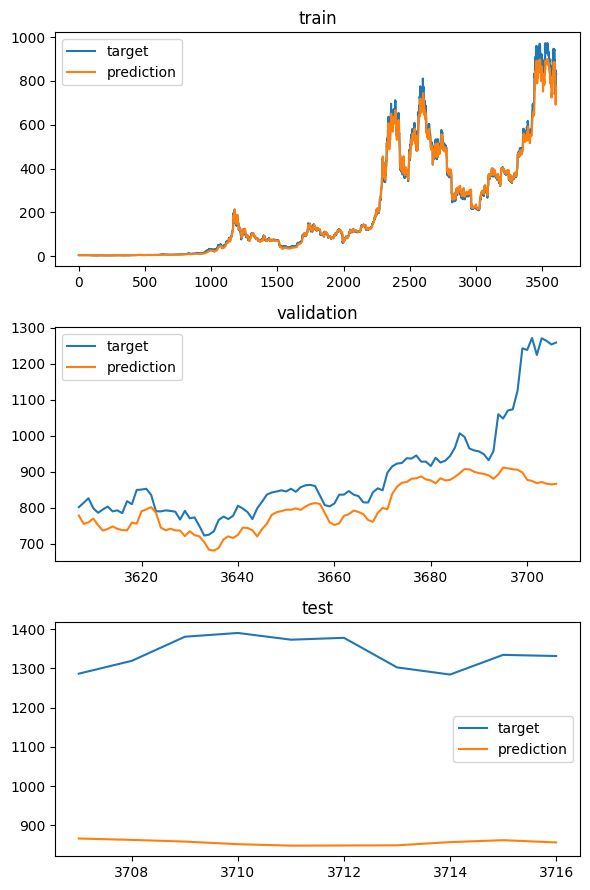

In [10]:
if __name__ == "__main__":
    import sys
    if 'ipykernel' in sys.modules:  # Jupyter Notebook에서 실행 중인지 확인
        # Jupyter에서 실행할 때는 기본값 사용
        args = Args()
    else:
        # 일반 Python 스크립트로 실행할 때는 argparse 사용
        parser = get_parser()
        args = parser.parse_args()
    
    main(args)